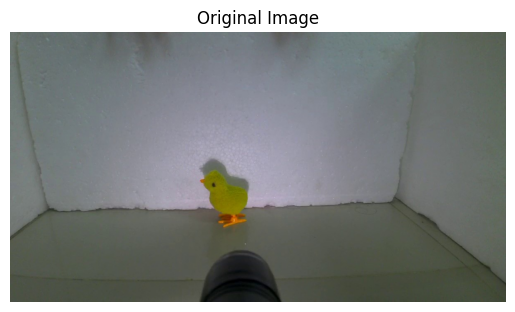

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------- โหลดและแสดงภาพต้นฉบับ ----------------
img = cv2.imread("Chicken.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

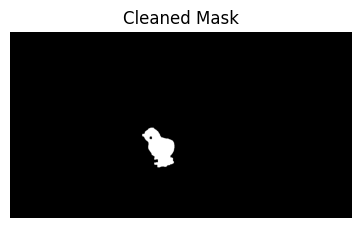

In [24]:
# ---------------- แปลงเป็น HSV ----------------
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# ช่วงสีส้มถึงเหลือง
lower_orange_yellow = np.array([5, 100, 100])
upper_orange_yellow = np.array([35, 255, 255])


# สร้าง mask
mask = cv2.inRange(hsv, lower_orange_yellow, upper_orange_yellow)

# ---------------- ทำความสะอาด mask ----------------
kernel = np.ones((6,6), np.uint8)

# ลบ noise จุดเล็ก ๆ
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# ปิดรูว่างเล็ก ๆ ภายในวัตถุ
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

# ---------------- ใช้ mask กับภาพ ----------------
res_clean = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_clean)

plt.figure(figsize=(15,5))
plt.subplot(1,3,2); plt.imshow(mask_clean, cmap="gray"); plt.title("Cleaned Mask"); plt.axis("off")
plt.show()


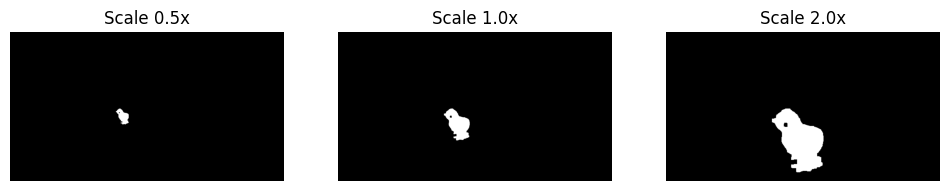

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ใช้ mask เป็นตัวอย่าง
img = mask_clean  

# หา bounding box ของวัตถุสีขาว
x, y, w, h = cv2.boundingRect(img)

# ตัดเฉพาะส่วนวัตถุ
object_crop = img[y:y+h, x:x+w]

# ขนาด scaling ที่ต้องการ (เล็ก / กลาง / ใหญ่)
scales = [0.5, 1.0, 2.0]
results = []

for s in scales:
    # resize วัตถุ
    new_w, new_h = int(w*s), int(h*s)
    resized_obj = cv2.resize(object_crop, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # สร้าง canvas ดำขนาดเท่าเดิม
    canvas = np.zeros_like(img)

    # ⚡ ใช้ตำแหน่งเดิม (x,y)
    end_x = x + new_w
    end_y = y + new_h

    # ตรวจสอบไม่ให้ออกนอกภาพ
    if end_x > canvas.shape[1]:
        end_x = canvas.shape[1]
    if end_y > canvas.shape[0]:
        end_y = canvas.shape[0]

    canvas[y:end_y, x:end_x] = resized_obj[0:(end_y-y), 0:(end_x-x)]

    results.append(canvas)

# ---------------- แสดงผล ----------------
fig, axes = plt.subplots(1, len(results), figsize=(12,4))
for ax, s, r in zip(axes, scales, results):
    ax.imshow(r, cmap="gray")
    ax.set_title(f"Scale {s}x")
    ax.axis("off")
plt.show()


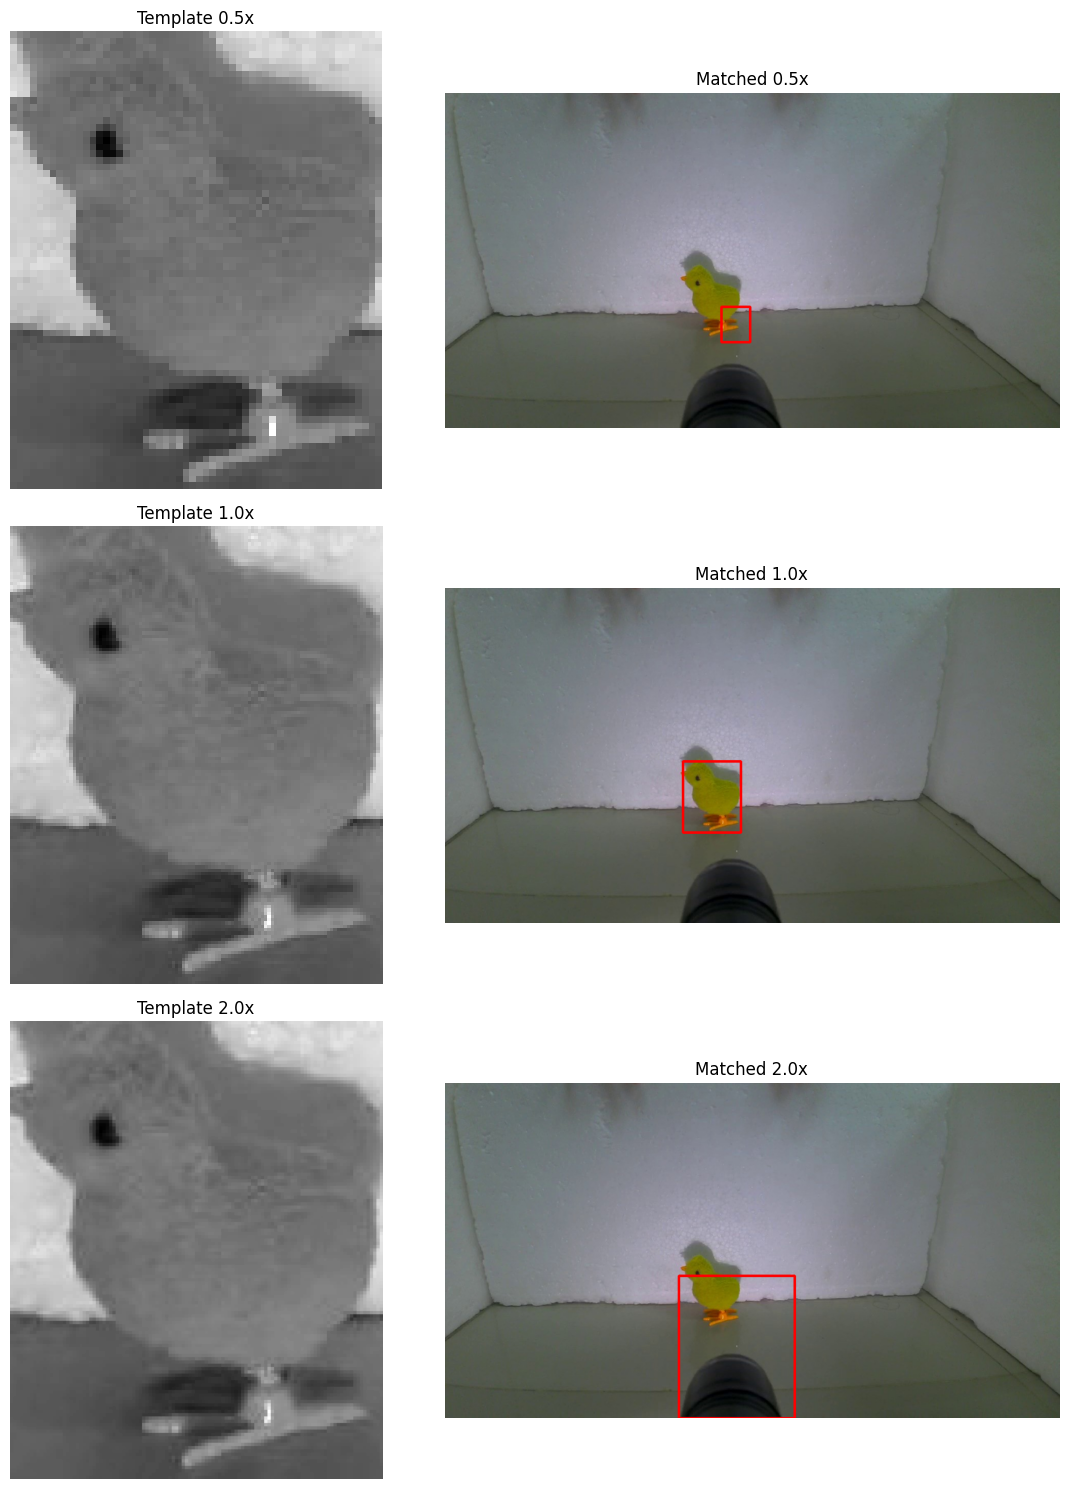

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------- ภาพ original ----------------
original = img_rgb.copy()
gray_original = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)

# ---------------- เตรียม Template 3 ขนาด ----------------
x, y, w, h = cv2.boundingRect(mask_clean)
object_crop = gray_original[y:y+h, x:x+w]

scales = [0.5, 1.0, 2.0]
templates = []

for s in scales:
    new_w, new_h = int(w*s), int(h*s)
    resized_template = cv2.resize(object_crop, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
    templates.append(resized_template)

# ---------------- Template Matching ----------------
matched_results = []

for temp, s in zip(templates, scales):
    # Match
    res = cv2.matchTemplate(gray_original, temp, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    top_left = max_loc
    bottom_right = (top_left[0] + temp.shape[1], top_left[1] + temp.shape[0])
    
    # ทำสำเนาภาพ original แล้ววาดกรอบ
    matched = original.copy()
    cv2.rectangle(matched, top_left, bottom_right, (255,0,0), 3)
    matched_results.append((temp, matched, s))

# ---------------- แสดงผล ----------------
fig, axes = plt.subplots(len(scales), 2, figsize=(12, 5*len(scales)))

for i, (temp, matched, s) in enumerate(matched_results):
    # แสดง Template
    axes[i,0].imshow(temp, cmap="gray")
    axes[i,0].set_title(f"Template {s}x")
    axes[i,0].axis("off")
    
    # แสดง Original + กรอบ match
    axes[i,1].imshow(matched)
    axes[i,1].set_title(f"Matched {s}x")
    axes[i,1].axis("off")

plt.tight_layout()
plt.show()
